# Price Elasticity & Risk Analysis 📉
(การวิเคราะห์ความยืดหยุ่นของราคาและความเสี่ยง)

โปรเจกต์นี้ประยุกต์ใช้ **Quantile Regression** ในการวิเคราะห์ความอ่อนไหวของอุปสงค์ (Demand Sensitivity) โดยให้มุมมองเชิงลึกที่ละเอียดกว่าโมเดลเชิงเส้นแบบดั้งเดิม

### ทำไมถึงสำคัญ:
การวิเคราะห์ด้วย Regression ทั่วไป (OLS) จะบอกได้แค่ผลกระทบ "โดยเฉลี่ย" ของราคาที่มีต่อยอดขาย แต่ Quantile Regression สามารถเปิดเผยความเสี่ยงได้ครบทุกมิติ:
- **ความเสี่ยงขาลง (10th Percentile):** ลูกค้าอ่อนไหวต่อราคาแค่ไหนในช่วงที่ยอดขายซบเซา?
- **โอกาสขาขึ้น (90th Percentile):** เรามีอำนาจในการกำหนดราคาเพิ่มขึ้นหรือไม่ในช่วงที่ความต้องการสินค้าพุ่งสูง?

### เทคโนโลยีที่ใช้:
- Python (Statsmodels, Pandas, Matplotlib)
- **Quantile Regression** สำหรับการสร้างโมเดลความเสี่ยงแบบ Non-parametric

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

# 1. Generate Synthetic Data
np.random.seed(42)
n_samples = 500

# Price: Between $10 and $100
prices = np.random.uniform(10, 100, n_samples)

# Base Demand: Higher price -> Lower demand (Negative slope)
# We act as if 'true' base demand is 100 - 0.8 * Price
base_demand = 100 - 0.8 * prices

# Noise: In reality, sales fluctuate. 
# Heteroscedasticity: The variance might increase at lower prices (more volatile behavior).
noise_variance = 10 + 0.2 * (100 - prices)  # More noise when cheaper
noise = np.random.normal(0, noise_variance, n_samples)

units_sold = base_demand + noise
# Ensure no negative sales
units_sold = np.maximum(0, units_sold)

df = pd.DataFrame({'Price': prices, 'Units_Sold': units_sold})

print("Data Preview:")
print(df.head())

Data Preview:
       Price  Units_Sold
0  43.708611   72.298255
1  95.564288   43.974709
2  75.879455   53.385623
3  63.879264   38.959916
4  24.041678   58.134097


In [2]:
# 2. Fit Regression Models

# OLS (Ordinary Least Squares) -> Measures the MEAN effect
model_ols = smf.ols('Units_Sold ~ Price', df).fit()

# Quantile Regressions -> Measures effect at specific percentiles
# q=0.1: Worst-case scenarios (Low demand periods)
# q=0.5: Median scenarios (Typical days)
# q=0.9: Best-case scenarios (High demand/Holidays)
model_q10 = smf.quantreg('Units_Sold ~ Price', df).fit(q=0.1)
model_q50 = smf.quantreg('Units_Sold ~ Price', df).fit(q=0.5)
model_q90 = smf.quantreg('Units_Sold ~ Price', df).fit(q=0.9)

# Extract parameters for visualization
print("\n--- Model Coefficients (Slope: Price Sensitivity) ---")
print(f"OLS (Average): {model_ols.params['Price']:.4f}")
print(f"Q10 (Low Sales): {model_q10.params['Price']:.4f}")
print(f"Q50 (Median):    {model_q50.params['Price']:.4f}")
print(f"Q90 (High Sales): {model_q90.params['Price']:.4f}")


--- Model Coefficients (Slope: Price Sensitivity) ---
OLS (Average): -0.7379
Q10 (Low Sales): -0.5196
Q50 (Median):    -0.7734
Q90 (High Sales): -0.9420


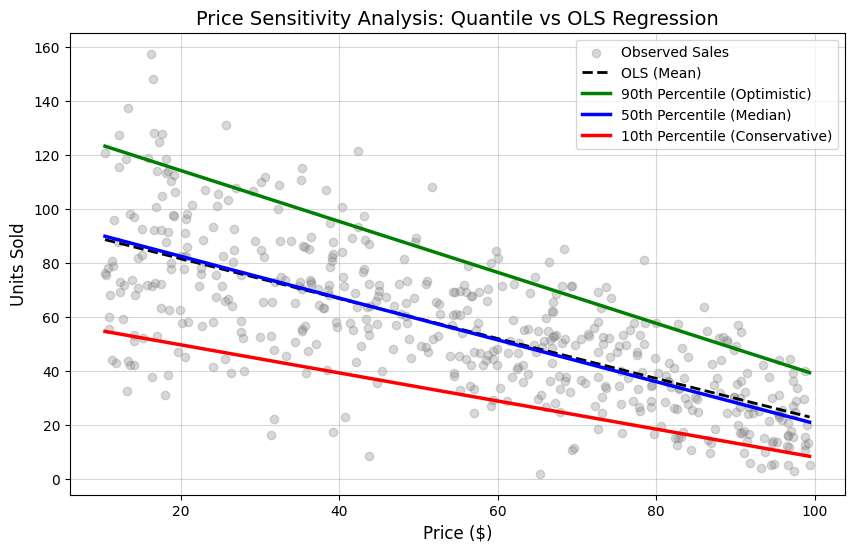

In [3]:
# 3. Visualization

plt.figure(figsize=(10, 6), dpi=100)

# Scatter plot of data
plt.scatter(df.Price, df.Units_Sold, alpha=0.3, color='gray', label='Observed Sales')

# Define price range for plotting lines
x_range = np.linspace(df.Price.min(), df.Price.max(), 100)
pred_data = pd.DataFrame({'Price': x_range})

# Plot Regression Lines
plt.plot(x_range, model_ols.predict(pred_data), color='black', linestyle='--', linewidth=2, label='OLS (Mean)')
plt.plot(x_range, model_q90.predict(pred_data), color='green', linewidth=2.5, label='90th Percentile (Optimistic)')
plt.plot(x_range, model_q50.predict(pred_data), color='blue', linewidth=2.5, label='50th Percentile (Median)')
plt.plot(x_range, model_q10.predict(pred_data), color='red', linewidth=2.5, label='10th Percentile (Conservative)')

plt.title('Price Sensitivity Analysis: Quantile vs OLS Regression', fontsize=14)
plt.xlabel('Price ($)', fontsize=12)
plt.ylabel('Units Sold', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

## Interpretation Guide

- **Red Line (10th Percentile):** Represents sales during "bad times." If this line is steeper (more negative slope) than the mean, it implies that price increases hurt you *more* when sales are already low.
- **Green Line (90th Percentile):** Represents sales during "good times" (e.g., peak season). A flatter slope here would suggest that when demand is high, customers are less sensitive to price changes.

This insight helps managers decide whether to discount (to protect the downside) or raise prices (to capture upside during peaks).